In [1]:
import numpy as np
from scipy import interpolate
import json
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
def computeH(im1_pts, im2_pts):
    N = im1_pts.shape[0] 
    A = []
    for i in range(N):
        x, y = im1_pts[i]
        x_prime, y_prime = im2_pts[i]

        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)

    # Solve for the null space of A using SVD
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))

    H /= H[2, 2]

    return H

In [5]:
with open('correspondance.json', 'r') as f:
    data = json.load(f)

im1_points = np.array(data["im1Points"])
im2_points = np.array(data["im2Points"])
img1 = plt.imread('images/img1.jpg')
img2 = plt.imread('images/img2.jpg')

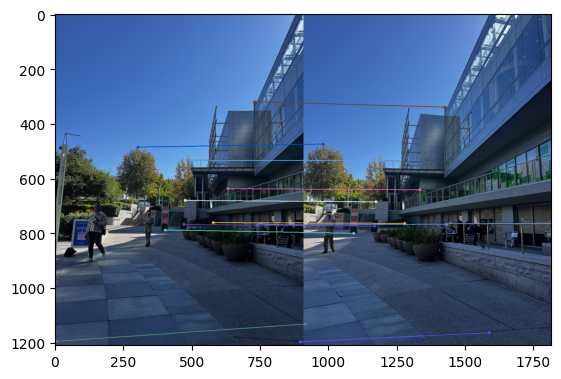

In [4]:
#draw corresponding points
combined_img = np.hstack((img1, img2))
new_points2 = im2_points.copy()
new_points2[:, 0] += img1.shape[1]
for pt1, pt2 in zip(im1_points, new_points2):
    color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for each line
    cv2.line(combined_img, tuple(pt1), tuple(pt2), color, 2)
    cv2.circle(combined_img, tuple(pt1), 5, color, -1)
    cv2.circle(combined_img, tuple(pt2), 5, color, -1)
plt.imsave('combined_correspondance.jpg', combined_img)
plt.imshow(combined_img)

In [7]:
from scipy.interpolate import griddata
def warpImage(im, H):
    """
    Warps an image using the given homography matrix H and returns the warped image and bounding box.
    Interpolation is performed using scipy.interpolate.griddata.

    Parameters:
    im : numpy.ndarray
        The input image to warp.
    H : numpy.ndarray
        The 3x3 homography matrix.

    Returns:
    warped_image : numpy.ndarray
        The warped image.
    bounding_box : tuple
        The bounding box ((x_min, y_min), (x_max, y_max)) of the warped image.
    """
    h, w = im.shape[:2]

    corners = np.array([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ])

    corners_homog = np.hstack((corners, np.ones((4, 1))))  # Shape: (4, 3)
    warped_corners = (H @ corners_homog.T).T  # Shape: (4, 3)
    warped_corners /= warped_corners[:, [2]]  # Normalize homogeneous coordinates

    # Compute the bounding box of the warped image
    x_coords = warped_corners[:, 0]
    y_coords = warped_corners[:, 1]
    x_min = int(np.floor(np.min(x_coords)))
    x_max = int(np.ceil(np.max(x_coords)))
    y_min = int(np.floor(np.min(y_coords)))
    y_max = int(np.ceil(np.max(y_coords)))

    # Compute the size of the output (warped) image
    width_warped = x_max - x_min + 1
    height_warped = y_max - y_min + 1

    # Create a meshgrid of (x, y) coordinates in the output image
    x_range = np.arange(x_min, x_max + 1)
    y_range = np.arange(y_min, y_max + 1)
    x_grid, y_grid = np.meshgrid(x_range, y_range)  # Shape: (height_warped, width_warped)

    # Flatten the coordinate grids
    x_dest_flat = x_grid.flatten()
    y_dest_flat = y_grid.flatten()

    # Stack destination coordinates
    dest_coords = np.vstack((x_dest_flat, y_dest_flat, np.ones_like(x_dest_flat)))  # Shape: (3, N)

    # Compute inverse homography
    H_inv = np.linalg.inv(H)

    # Map destination pixels back to source image coordinates using inverse homography
    src_coords = H_inv @ dest_coords  # Shape: (3, N)
    src_coords /= src_coords[2, :]  # Normalize homogeneous coordinates

    x_src = src_coords[0, :]
    y_src = src_coords[1, :]

    # Prepare source pixel coordinates
    x_src_flat = x_src
    y_src_flat = y_src

    # Prepare valid mask for points inside the source image
    valid_mask = (
        (x_src_flat >= 0) & (x_src_flat <= w - 1) &
        (y_src_flat >= 0) & (y_src_flat <= h - 1)
    )

    # Extract valid source and destination coordinates
    x_src_valid = x_src_flat[valid_mask]
    y_src_valid = y_src_flat[valid_mask]
    x_dest_valid = x_dest_flat[valid_mask]
    y_dest_valid = y_dest_flat[valid_mask]

    # Prepare output warped image
    warped_image = np.zeros((height_warped, width_warped, im.shape[2]), dtype=im.dtype)

    # Interpolate each channel
    for c in range(im.shape[2]):
        # Flatten the source image channel
        im_channel = im[:, :, c]

        # Use griddata for interpolation
        values = im_channel[y_src_valid.astype(np.int32), x_src_valid.astype(np.int32)]
        points = np.vstack((x_src_valid, y_src_valid)).T  # Source coordinates

        # Create a grid of destination points
        grid_x, grid_y = np.meshgrid(
            np.arange(x_min, x_max + 1),
            np.arange(y_min, y_max + 1)
        )
        grid_points = np.vstack((x_dest_valid, y_dest_valid)).T  # Destination coordinates

        # Interpolate values at destination points
        interpolated_values = griddata(
            points, values, grid_points, method='linear', fill_value=0
        )

        # Reshape interpolated values to the warped image shape
        warped_channel = np.zeros((height_warped, width_warped), dtype=im.dtype)
        warped_channel_flat = warped_channel.flatten()
        warped_channel_flat[valid_mask] = interpolated_values
        warped_channel = warped_channel_flat.reshape((height_warped, width_warped))

        # Assign the interpolated channel to the warped image
        warped_image[:, :, c] = warped_channel

    # Define the bounding box of the warped image
    bounding_box = ((x_min, y_min), (x_max, y_max))

    return warped_image, bounding_box

In [28]:
h, w = img1.shape[:2]
homography = computeH(im1_points, im2_points)
warpedimg, bounding_box = warpImage(img1, homography)

-1162 676 -1122 1147


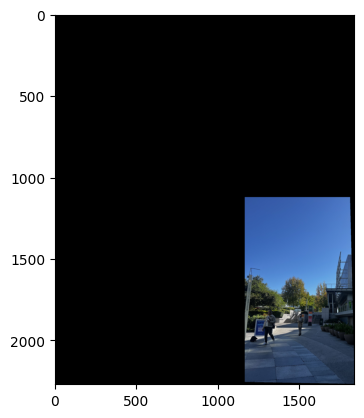

In [13]:
plt.imshow(warpedimg)

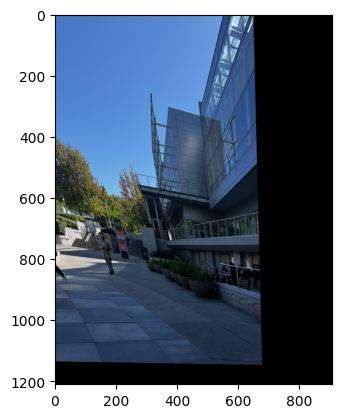

In [10]:
out = cv2.warpPerspective(img1, homography, (img1.shape[1], img1.shape[0]))
plt.imshow(out)

In [14]:
def stitch_images(image1_warped, image2, bounding_box):
    new_height, new_width = image1_warped.shape[:2]
    height2, width2 = image2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    image_full = np.zeros(((new_height + height2), (new_width + width2), 3))
    image_full[0:image1_warped.shape[0], 0:image1_warped.shape[1]] = image1_warped
    
    for y in range(height2):
        for x in range(width2):
            x_new, y_new = x + x_shift , y + y_shift
            image_full[y_new][x_new] = image2[y][x]
    
    if x_shift < 0:
        image_full = np.roll(image_full, -x_shift, axis=1)
    if y_shift < 0:
        image_full = np.roll(image_full, -y_shift, axis=0)
    
    image_full = delete_black(image_full)
    
    return image_full.astype(np.uint8)

In [17]:
image_full = stitch_images(out, img2, bounding_box)
cv2.imwrite('image_full.jpg', cv2.cvtColor(image_full, cv2.COLOR_RGB2BGR))
plt.imshow(image_full)

IndexError: index 1814 is out of bounds for axis 0 with size 1814

In [26]:
def homo(xy_tuple, H):
    x, y = xy_tuple
    input_px = np.array(([x], [y], [1]))
    output_px = H.dot(input_px)
    output_px /= output_px[2]
    return output_px[0], output_px[1]
def get_bounding_box(img, H):
    min_x = np.inf
    min_y = np.inf
    max_x = np.NINF
    max_y = np.NINF
    src_to_dest_map = dict()
    height, width = img.shape[:2]
    for y_src in range(height):
        for x_src in range(width):
            x_dest, y_dest = homo((x_src, y_src), H)
            src_to_dest_map[x_src, y_src] = (x_dest, y_dest)
            min_x = int(min(min_x, x_dest))
            min_y = int(min(min_y, y_dest))
            max_x = int(max(max_x, x_dest))
            max_y = int(max(max_y, y_dest))
    return min_x, min_y, max_x, max_y, src_to_dest_map

In [31]:
def get_subpixels(img, x, y):
    subpixels = [
        (int(np.floor(x)), int(np.floor(y))),
        (int(np.ceil(x)), int(np.floor(y))), 
        (int(np.floor(x)), int(np.ceil(y))), 
        (int(np.ceil(x)), int(np.ceil(y)))
    ]
    #print(subpixels)
    values = [
        img[subpixels[0][1]][subpixels[0][0]],
        img[subpixels[1][1]][subpixels[1][0]],
        img[subpixels[2][1]][subpixels[2][0]],
        img[subpixels[3][1]][subpixels[3][0]]
    ]
    
    subpixels = np.c_[subpixels, values]

    return np.array(subpixels).astype(int)
    
def warp_image(img, H):
    min_x, min_y, max_x, max_y, src_to_dest_map = get_bounding_box(img, H)
    #print(min_x, min_y, max_x, max_y)
    bounding_box = ((min_x, min_y), (max_x, max_y))
    warped_image = np.zeros((max_y - min_y + 2, max_x - min_x + 2, 3))
    accumulator = np.copy(warped_image)
    
    height, width = img.shape[:2]
    new_height, new_width = warped_image.shape[:2]
    
    for x_src in range(width):
        for y_src in range(height):
            x_dest, y_dest = src_to_dest_map[(x_src, y_src)]
            x_dest -= min_x
            y_dest -= min_y
            subpixels = get_subpixels(warped_image, x_dest, y_dest)[:,:2]
            for sp in range(len(subpixels)):
                for ch in range(3):
                    #print(subpixels)
                    warped_image[subpixels[sp][1]][subpixels[sp][0]][ch] += img[y_src][x_src][ch]
                    accumulator[subpixels[sp][1]][subpixels[sp][0]][ch] += 1
    # Averaging each value in warped image by value in accumulator        
    for x_dest in range(new_width):
        for y_dest in range(new_height):
            for ch in range(3):
                if warped_image[y_dest][x_dest][ch] > 0:
                    warped_image[y_dest][x_dest][ch] = int(np.round(warped_image[y_dest][x_dest][ch] / accumulator[y_dest][x_dest][ch]))
    
    return warped_image.astype(np.uint8), bounding_box

/Users/michellechen/miniconda3/envs/tensorboard/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:743: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

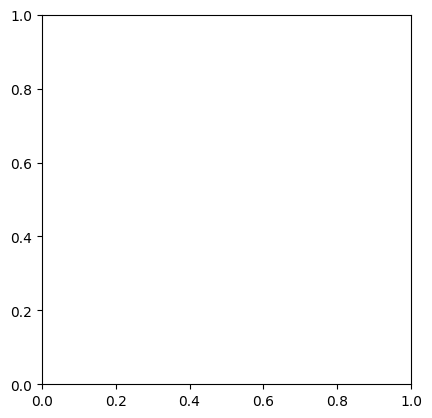

In [32]:
res = warp_image(img1, homography)

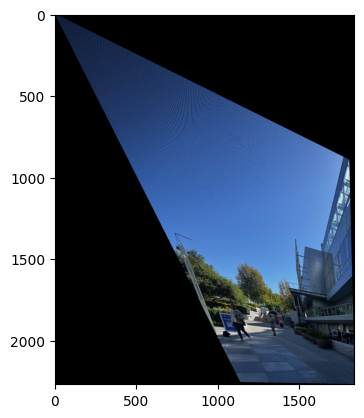

In [34]:
plt.imshow(res[0])

In [4]:
def get_matches(image1, image2, max_matches=100, ratio_threshold=0.5):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold*n.distance:
            good_matches.append(m)
            if len(good_matches) == max_matches:
                break
    
    return kp1, kp2, good_matches

kp1, kp2, good_matches = get_matches(img1, img2)
kp1_good = np.array([kp1[mat.queryIdx].pt for mat in good_matches], dtype=np.float32)
kp2_good = np.array([kp2[mat.trainIdx].pt for mat in good_matches], dtype=np.float32)

H, _ = cv2.findHomography(kp1_good, kp2_good)

In [8]:
h, w = img1.shape[:2]
homography = computeH(im1_points, im2_points)
warpedimg, bounding_box = warpImage(img1, H)

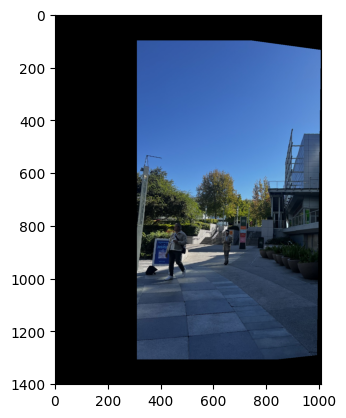

In [9]:
plt.imshow(warpedimg)

In [10]:
def warpImage(im, H):
    h, w = im.shape[:2]

    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [w, h, 1],
        [0, h, 1]
    ]).T
    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]
    x_min = int(np.floor(np.min(warped_corners[0])))
    x_max = int(np.ceil(np.max(warped_corners[0])))
    y_min = int(np.floor(np.min(warped_corners[1])))
    y_max = int(np.ceil(np.max(warped_corners[1])))
    width_warped = x_max - x_min + 1
    height_warped = y_max - y_min + 1

    warped_image = np.zeros((height_warped, width_warped, im.shape[2]), dtype=np.float64)
    accumulator = np.zeros((height_warped, width_warped, im.shape[2]), dtype=np.float64)

    for y_src in range(h):
        for x_src in range(w):
            src_pixel = np.array([x_src, y_src, 1])
            dest_pixel = H @ src_pixel
            dest_pixel /= dest_pixel[2]
            x_dest, y_dest = dest_pixel[:2]
            
            x_dest_int = int(np.floor(x_dest)) - x_min
            y_dest_int = int(np.floor(y_dest)) - y_min

            if 0 <= x_dest_int < width_warped and 0 <= y_dest_int < height_warped:
                x_frac = x_dest - np.floor(x_dest)
                y_frac = y_dest - np.floor(y_dest)

                weights = [
                    ((1 - x_frac) * (1 - y_frac), (0, 0)),
                    (x_frac * (1 - y_frac), (1, 0)),
                    ((1 - x_frac) * y_frac, (0, 1)),
                    (x_frac * y_frac, (1, 1))
                ]

                for weight, (dx, dy) in weights:
                    x_idx = x_dest_int + dx
                    y_idx = y_dest_int + dy
                    if 0 <= x_idx < width_warped and 0 <= y_idx < height_warped:
                        warped_image[int(y_idx), int(x_idx)] += im[y_src, x_src] * weight
                        accumulator[int(y_idx), int(x_idx)] += weight

    valid = accumulator > 0
    warped_image[valid] /= accumulator[valid]

    warped_image = np.clip(warped_image, 0, 255).astype(np.uint8)

    bounding_box = ((x_min, y_min), (x_max, y_max))

    return warped_image, bounding_box

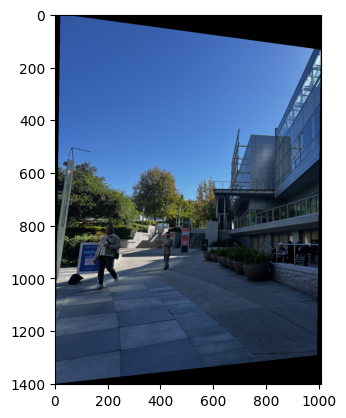

In [11]:
h, w = img1.shape[:2]
homography = computeH(im1_points, im2_points)
warpedimg, bounding_box = warpImage(img1, H)
plt.imshow(warpedimg)

In [6]:
import numpy as np
from scipy.interpolate import griddata

def warpImage2(im, H):
    h, w = im.shape[:2]

    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [w, h, 1],
        [0, h, 1]
    ]).T

    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]  # Normalize

    x_min = int(np.floor(np.min(warped_corners[0])))
    x_max = int(np.ceil(np.max(warped_corners[0])))
    y_min = int(np.floor(np.min(warped_corners[1])))
    y_max = int(np.ceil(np.max(warped_corners[1])))
    width_warped = x_max - x_min + 1
    height_warped = y_max - y_min + 1

    x, y = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
    grid_points = np.column_stack((x.flatten(), y.flatten()))

    x_src, y_src = np.meshgrid(np.arange(w), np.arange(h))
    src_points = np.column_stack((x_src.flatten(), y_src.flatten()))

    H_inv = np.linalg.inv(H)
    src_homogeneous = H_inv @ np.vstack((grid_points.T, np.ones(grid_points.shape[0])))
    src_points_warped = src_homogeneous[:2, :] / src_homogeneous[2, :]
    src_points_warped = src_points_warped.T  # Transpose here instead of earlier

    warped_image = np.zeros((height_warped, width_warped, im.shape[2]), dtype=np.float64)
    for channel in range(im.shape[2]):
        values = im[:, :, channel].flatten()
        warped_channel = griddata(
            src_points, values, src_points_warped, method='linear', fill_value=0
        )
        warped_image[:, :, channel] = warped_channel.reshape((height_warped, width_warped))

    warped_image = np.clip(warped_image, 0, 255).astype(np.uint8)

    bounding_box = ((x_min, y_min), (x_max, y_max))

    return warped_image, bounding_box

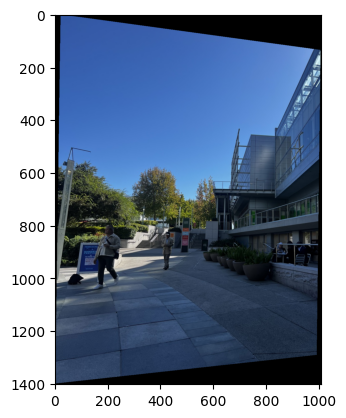

In [7]:
img1 = plt.imread('images/img1.jpg')
img2 = plt.imread('images/img2.jpg')
h, w = img1.shape[:2]
warpedimg, bounding_box = warpImage2(img1, H)
plt.imshow(warpedimg)

In [10]:
def mosaic(img1, img2, homography):
    
    warpedimg, bounding_box = warpImage2(img1, homography)
    
    h1, w1 = warpedimg.shape[:2]
    h2, w2 = img2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    res = np.zeros(((h1 + h2), (w1 + w2), 3))
    res[0:warpedimg.shape[0], 0:warpedimg.shape[1]] = warpedimg
    
    for y in range(h2):
        for x in range(w2):
            x_new, y_new = x + x_shift , y + y_shift
            res[y_new][x_new] = img2[y][x]
    
    if x_shift < 0:
        res = np.roll(res, -x_shift, axis=1)
    if y_shift < 0:
        res = np.roll(res, -y_shift, axis=0)
    
    return res.astype(np.uint8)

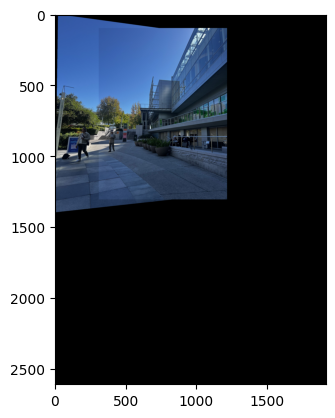

In [11]:
mosaic_image = mosaic(img1, img2, H)

In [2]:
import cv2
import numpy as np

def simple_blend(img1, img2, dist1, dist2, alpha=0.6, beta=0.4):
    # Ensure input images are float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Low pass
    low_pass_img1 = cv2.GaussianBlur(img1, (5, 5), 1)
    low_pass_img2 = cv2.GaussianBlur(img2, (5, 5), 1)

    dist1_normalized = dist1 / (np.max(dist1) + 1e-6)
    dist2_normalized = dist2 / (np.max(dist2) + 1e-6)
    weights = dist1_normalized / (dist1_normalized + dist2_normalized + 1e-6)

    low_pass_blended = (weights[..., np.newaxis] * low_pass_img1 + 
                        (1 - weights[..., np.newaxis]) * low_pass_img2)

    # High pass
    high_pass_img1 = cv2.subtract(img1, low_pass_img1)
    high_pass_img2 = cv2.subtract(img2, low_pass_img2)

    high_mask = dist1 > dist2
    high_pass_blended = np.where(high_mask[..., np.newaxis], high_pass_img1, high_pass_img2)

    # Combine low and high frequency components
    final_image = cv2.addWeighted(low_pass_blended, alpha, high_pass_blended, beta, 0)
    final_image = np.clip(final_image, 0, 255).astype(np.uint8)

    return final_image

def mosaic_blend(img1, img2, homography):
    warpedimg, bounding_box = warpImage2(img1, homography)
    
    h1, w1 = warpedimg.shape[:2]
    h2, w2 = img2.shape[:2]
    x_shift = -bounding_box[0][0]
    y_shift = -bounding_box[0][1]
    
    # Create a canvas large enough to hold both images
    h_total = max(h1, h2 + y_shift)
    w_total = max(w1, w2 + x_shift)
    canvas1 = np.zeros((h_total, w_total, 3), dtype=np.float32)
    canvas2 = np.zeros((h_total, w_total, 3), dtype=np.float32)
    
    # Place warped image on canvas1
    canvas1[0:h1, 0:w1] = warpedimg.astype(np.float32)
    
    # Place second image on canvas2
    y_start = max(0, y_shift)
    x_start = max(0, x_shift)
    canvas2[y_start:y_start+h2, x_start:x_start+w2] = img2.astype(np.float32)
    
    # Compute distance transforms
    gray1 = cv2.cvtColor(canvas1.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(canvas2.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, binary1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    _, binary2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)
    dist1 = cv2.distanceTransform(binary1, cv2.DIST_L2, 5)
    dist2 = cv2.distanceTransform(binary2, cv2.DIST_L2, 5)
    
    # Smooth the distance transforms
    dist1 = cv2.GaussianBlur(dist1, (21, 21), 5)
    dist2 = cv2.GaussianBlur(dist2, (21, 21), 5)
    
    # Blend the images
    blended = simple_blend(canvas1, canvas2, dist1, dist2)
    
    return blended

In [44]:
result = mosaic_blend(img1, img2, H)

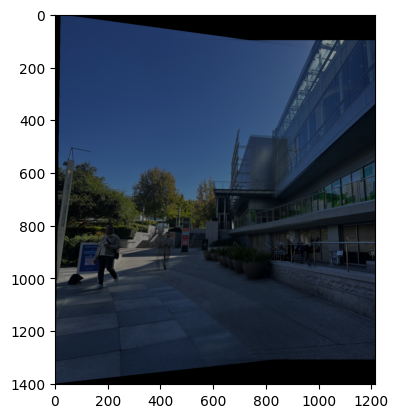

In [45]:
plt.imshow(result)

In [46]:
plt.imsave("2_blend.png", result)

In [7]:
img1 = plt.imread("images/1.jpg")
img2 = plt.imread("images/2.jpg")
kp1, kp2, good_matches = get_matches(img1, img2)
kp1_good = np.array([kp1[mat.queryIdx].pt for mat in good_matches], dtype=np.float32)
kp2_good = np.array([kp2[mat.trainIdx].pt for mat in good_matches], dtype=np.float32)

H, _ = cv2.findHomography(kp1_good, kp2_good)
res = mosaic_blend(img1, img2, H)

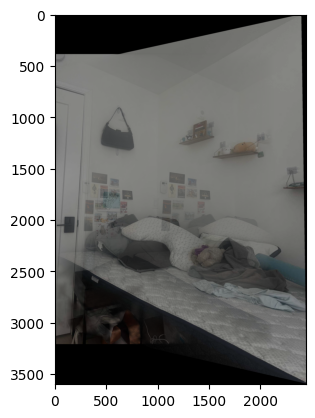

In [8]:
plt.imshow(res)

In [9]:
plt.imsave("2_blend_2.png", res)